In [1]:
% matplotlib inline

# Chebyshev polynomials

This is method to estimate the exponential of a matrix based on a polynomial approximation exponential function for an argument $|x|<1$. The idea is that, given a function $f(\omega)$ which is defined in the complex domain $\omega \in[-i,i]$, it can be very well approximated using the Chebyshev polynomials
\begin{eqnarray}
T_0 &=&1,\\
T_1 &=&x,\\
T_n &=& 2x T_k(x) - T_{k-1}(x)
\end{eqnarray}
using the orthonormal expansion
$$f(\omega) = \sum_k a_k T_k(\omega),$$
where $a_k$ are the projection of the function on that domain with a particular measure
$$a_k = -i\int_{-i}^i (1-|\omega|^2)^{-1/2}f(\omega) T_k(\omega)\mathrm{d}\omega.$$
We use this expansion to approximate the evolution operator
$$\exp(-i \Delta t H) = e^{-i r_+}\exp(r_- A),$$
where $r_\pm = \Delta t(\lambda_{max}\pm\lambda_{min})/2$ is built from the maximum and minimum eigenvalues $\lambda_{max}$ and $\lambda_{min}$ of $H$, to construct an operator
$$B = \frac{-i}{r_-}(\Delta t H - r_+),$$
whose spectrum lays in $[-i,i]$. Using this, we have
$$\exp(-i \Delta t H) = e^{-ir_+}\left[J_0(r_-) + 2\sum_k J_k(r_-)T_k(B)\right],$$
where $J_k(x)$ are the Bessel functions of the first kind.

In [40]:
import scipy.sparse.linalg
from scipy.special import jn
import scipy.linalg as la
import scipy.sparse.linalg as sla

class ChebyshevExpm:
    """
    This object is created to compute $exp(-i*H*dt)*v$ using the Chebyshev series
    to approximate the exponential. The object does some preconditioning or scaling
    of the operator based on the range of eigenvalues and 'factor', transforming it
    to $exp(-i*A*R)*v$ where B has eigenvalues in [-1,1] and R is a real number.
    
    dt: a real number
    order: number of terms in the Chebyshev expansion
    EM, em: Max and Min energy, which is needed for the argument of the Bessel function R and to normalize the action of fham
    """
    def __init__(self, H, shape=()):
        #
        # The method demands that the eigenvalues be in the range [-1,1]
        # We need analyze the operator to estimate a range of eigenvalues
        # and rescale the operator "A*factor" to a smaller range.
        #
        if callable(H):
            self.H = scipy.sparse.linalg.LinearOperator(shape,matvec=A)
        else:
            self.H = H
        largestEig = scipy.sparse.linalg.eigs(self.H, k=1, which='LM', return_eigenvectors=0)
        self.largestEig = abs(largestEig)
        self.smallestEig = -largestEig
    
    def apply(self, v, order=100, dt=1.0, tolerance=0):
        
        rp = dt * (self.largestEig + self.smallestEig) / 2
        rm = dt * (self.largestEig - self.smallestEig) / 2
        
        # Apply a version of A that is shifted and rescaled 
        def Btimes(phi):
            return ((self.H @ phi) * (dt/rm) - phi * (rp/rm))
    
        # Bessel coefficients ak, plus imaginary parts from chebyshev polynomials    
        ak = jn(np.arange(0,order), rm)
        ak = ak * ((-1j)**np.arange(0,order))
    
        # Zeroth order
        phi0 = v
        cheb = ak[0] * phi0
    
        #First order
        phi1 = Btimes(phi0)
        cheb += 2 * ak[1] * phi1
    
        # Higher orders
        for jj in range(2,order):
            phi2 = 2 * Btimes(phi1) - phi0
            tmp = 2 * ak[jj] * phi2
            if tolerance and (la.norm(tmp)/la.norm(cheb) <= tolerance):
                break
            cheb += tmp
            phi0 = phi1
            phi1 = phi2

        return cheb * np.exp(-1j*dt*rp)
    
def chebyshevExpm(A, v, **kwargs):
    aux = ChebyshevExpm(A)
    return aux.apply(v, **kwargs)

# Lanczos exponential

In this file we design and test a version of the exponential that works using the Krylov basis without reorthogonalization, taking as input any object that acts as a matrix or linear operator.

Our goal is to compute a  function $f(A)$ of some linear operator $A$, acting on a vector $v_0$. The method to implement this is based on building an approximation to $f(A)*v_0$ in the Krylov space of vectors given by
$$K = \text{lin}\{ v, A v, A^2 v, \ldots \}$$
Fortunately, this space of vectors can be constructed from an orthogonal set of vectors
$$v_n \propto A v_{n-1} - \sum_{m\leq n} (v_{m}^\dagger A v_{n-1}) v_{m}$$
where $v_1=v$ is the initial vector mentioned above and
$$K = \text{lin}\{v_1,v_2\ldots\}$$
Fortunately for us, two things happen. The first one is that the projection of $A$ onto the basis $\{v_n\}$ is very simple
$$T_{mm}:=(v_{m}^\dagger A v_{n})={\begin{pmatrix}\alpha _{1}&\beta _{2}&&&&0\\\beta _{2}&\alpha _{2}&\beta _{3}&&&\\&\beta _{3}&\alpha _{3}&\ddots &&\\&&\ddots &\ddots &\beta _{m-1}&\\&&&\beta _{m-1}&\alpha _{m-1}&\beta _{m}\\0&&&&\beta _{m}&\alpha _{m}\\\end{pmatrix}}$$
The second one is that the iterative construction of the orthonormal basis is very simple and involves only one product of matrix times a vector, and two additions
$$v_{n+1} = \frac{1}{\beta_{n+1}}(A v_n - \alpha_n v_n - \beta_n v_{n-1})$$
$$\alpha_n = (v_n^\dagger A v_n)$$
$$\beta_n = (v_{n-1}^\dagger A v_n)$$

All this allows us to define approximations to the exponential that are usually written in the form
$$\exp(-\tau A) v \simeq V_m \exp(-\tau T) e_1 + \varepsilon_m$$
where $V_m$ is the matrix that has as columns the $\{v_i\}_{i=1}^m$ vectors, $e_1$ is the vector which is only one in the first element and the error $\varepsilon_m$ depends on the spectral radius of $A$

It is important to know how many vectors we need to compute so as to make the error $\varepsilon_m$ small enough. There exist various a-priori estimates that depend on the spectral radius of $A$, the factor $\tau$ and the order of approximation $m$. When $A$ is skew-symmetric, a good upper bound is
$$\varepsilon_m \leq 12 e^{-(\rho\tau)^2/m}\left(\frac{e\rho\tau}{m}\right)^m < \frac{\Vert A\Vert^m}{m!}$$
provided $m > 2\rho\tau$. Another upper bound is
$$\varepsilon_m < \frac{\Vert A\Vert^m}{m!},\quad m > \Vert A\Vert$$
Neither of them is too tight, but it could serve us to guess a good starting point.

In our algorithm below, we do not rely so much on a-priori bounds. Instead we use a guess for the order of approximation and then verify it with an a-posteriori bound. This later bound uses the information on the exponential of the matrix $T$, as well as the latest $\beta$ that has been computed
$$\Vert\varepsilon_m\Vert \leq \left[exp(-\tau T)\right]_{m,1}\times |\beta_{m}|$$
We use this bound to repeatedly increase the number of vectors until convergence. Note, however, that there is a limit in the precission imposed by the numerical errors in the computer. This has to be taken in to account to stop the recursion when we hit that wall.

In [43]:
import numpy as np
import scipy.linalg as la

class LanczosExpm:
    def __init__(self, H):
        #
        # H can be a function, a matrix, a sparse matrix, etc. We construct
        # a linear operator in all cases, which is a general abstraction that
        # numpy can work with and allows multiplication times a vector '@'
        #
        if callable(H):
            self.H = sla.LinearOperator((d,d),matvec=H)
        else:
            self.H = H
        #
        # Estimate the spectral range of H, computing the smallest and
        # largest eigenvalues. ARPACK in standard Python is not good at
        # computing small values. We thus use a trick of computing the
        # largest magnitude X and assume the spectrum is in [-X,X]
        #
        self.Hnorm = abs(sla.eigs(H, k=1, which='LM', return_eigenvectors=0)[0])
    
    def estimateOrder(self, dt=1.0):
        return int(3*self.Hnorm*dt+1)

    def apply(self, v, dt=1.0, order=0, tol=1e-14):
        # This function has two ways to operate: if we provide an order,
        # it applies the Lanczos expansion up to that basis size; otherwise
        # it estimates the number of vectors based on the norm of the matrix
        # that we will exponentiate (which was estimated before in __init__)
        if order == 0:
            nmax = self.estimateOrder(dt)
        else:
            nmax = order
        #
        # Construct a projected version of the matrix 'H' on the
        # Krylov subspace generated around vector 'v'
        #
        v = np.array(v)
        vnrm = la.norm(v)
        vnm1 = vn = v / vnrm
        α = []
        β = [0.0]
        start = 0
        lasterr = 1.0
        while True:
            #
            # Iteratively extend the Krylov basis using the lanczos
            # recursion without restart or reorthogonalization.
            #
            for n in range(start, nmax):
                w = (self.H @ vn)
                α.append(np.dot(w, vn))
                w = w - α[n] * vn - β[n] * vnm1
                vnm1 = vn
                aux = la.norm(w)
                β.append(aux)
                vn = w / aux
            #
            # We diagonalize the banded matrix formed by α and β and
            # use that to compute the exponential of the effective
            # truncated matrix. This also allows us to estimate the error
            # due to the Lanczos method.
            #
            w, u = scipy.linalg.eig_banded(np.array([β[:-1],α]))
            fHt = u @ (np.exp(-1j*dt*w) * u[0,:].conj())
            err = abs(fHt[n]*β[n+1])
            if err < tol:
                break
            if lasterr < err or nmax == v.size:
                print('Lanczos failed to converge at ', n, ' iterations')
                break
            nmax = min(int(1.5*nmax+1), v.size)
        #
        # Given the approximation of the exponential, recompute the
        # Lanczos basis 
        #
        vnm1 = vn = v
        output = fHt[0] * vn
        for n in range(1, nmax):
            w = (self.H @ vn) - α[n-1] * vn - β[n-1] * vnm1
            vnm1 = vn
            vn = w / β[n]
            output = output + fHt[n] * vn
        return vnrm * output
    
def lanczosExpm(A, v, **kwargs):
    aux = LanczosExpm(A)
    return aux.apply(v, **kwargs)

# Study of errors

In [44]:
import scipy.sparse.linalg as sla
import math
import matplotlib.pyplot as plt

def chebyTest1(size, **kw):
    factor = 1.0
    if ('factor' in kw):
        factor = kw['factor']
    #
    # Create a random Hermitian matrix and a vector
    #
    A = np.random.rand(size,size)
    A = np.dot(A, A.T)
    v = np.random.rand(size)
    v = v / la.norm(v)
    #
    # Numerically exact exponential
    #
    w1 = la.expm(-1j * A * factor) @ v
    #
    # Set of orders that we wish to test
    #
    them = [m for m in range(3,size,4)]
    #
    # Estimate operator norm
    #
    Anrm = abs(sla.eigs(A, k=1, which='LM', return_eigenvectors=0)[0]*factor)
    mmin = Anrm
    #
    # Error estimates for Lanczos
    #
    rho = Anrm/4.0
    est = [abs(12*math.exp(m-rho*rho/m)*(rho/m)**m) for m in them]
    #
    # Error estimates for Lanczos (2nd, bit worse)
    #
    rho = Anrm/4.0
    est2 = [abs(2*math.exp(m*math.log(Anrm/2)-math.lgamma(m))) for m in them]
    #
    # Actual Lanczos errors
    #
    aux = LanczosExpm(A)
    err1 = [la.norm(w1 - aux.apply(v,order=m,dt=factor)) for m in them]
    #
    # Selfregulated Lanczos errors
    #
    aux = LanczosExpm(A)
    err1b = [la.norm(w1 - aux.apply(v,dt=factor))
             for m in them]
    #
    # Chebyshev class errors
    #
    err3 = [la.norm(w1 - chebyshevExpm(A,v,dt=factor,order=m)) for m in them]
    ax = plt.gca()
    ax.plot(them,est,'--',them,est2,'--',
            them,err1,'-',them,err1b,'-',them,err3,'-.',
            [mmin,mmin],[1e-16,10],'--.')
    ax.set_yscale('log')
    ax.set_xlabel('Lanczos No. vectors')
    ax.set_ylabel('Exponential error');
    ax.legend(['Lanczos bound','Lanczos bound2',
               'Lanczos fixed order','LanczosExpm','ChebyshevExpm',
              'OrderEstimate']);
    return ax

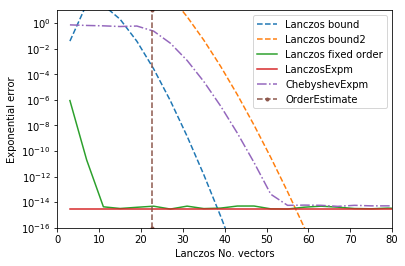

In [45]:
ax = chebyTest1(300, factor=1/1000.0)
ax.set_ylim([1e-16,10])
ax.set_xlim([0,80]);

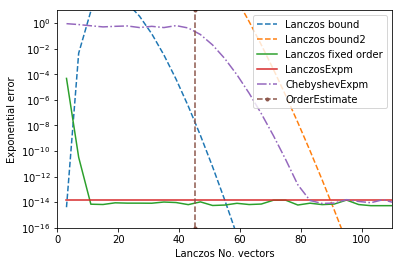

In [46]:
ax = chebyTest1(300, factor=1/500.0)
ax.set_ylim([1e-16,10])
ax.set_xlim([0,110]);

# Timing

In [47]:
import scipy.sparse.linalg as sla
import math
import matplotlib.pyplot as plt
import time

def lanczosTiming(size, chebyshev_order=100, factor=1.0, iterations=100):
    #
    # Create a random Hermitian matrix and a vector
    #
    A = np.random.rand(size,size)
    A = np.dot(A, A.T)
    v = np.random.rand(size)
    v = v / la.norm(v)
    #
    aux = LanczosExpm(A)
    t = time.process_time()
    for i in range(0,iterations):
        aux.apply(v,dt=factor)
    t = (time.process_time() - t)/iterations
    print('LanczosExpm t=',t,'s / iteration')
    #
    aux = ChebyshevExpm(A)
    t = time.process_time()
    for i in range(0,iterations):
        aux.apply(v,dt=factor,order=chebyshev_order)
    t = (time.process_time() - t)/iterations
    print('Chebyshev t=',t,'s / iteration')

In [50]:
lanczosTiming(300, chebyshev_order=60, factor=1/1000)

LanczosExpm t= 0.110625 s / iteration
Chebyshev t= 0.493125 s / iteration


In [52]:
lanczosTiming(300, chebyshev_order=90, factor=1/500)

LanczosExpm t= 0.21546875 s / iteration
Chebyshev t= 0.84359375 s / iteration
